# Chia Pudding Oscillation

Replicate pyRheo oscillatory fits on chia pudding and compare generalized vs fractional models.

**Data:** examples/data/pyRheo/chia_pudding/oscillation_chia_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:20:06,512:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load frequency sweep data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'chia_pudding'
df = pd.read_csv(DATA_DIR / 'oscillation_chia_data.csv')
df.columns = df.columns.str.strip()

omega = df['Angular Frequency'].to_numpy()  # rad/s from source
freq_hz = omega / (2 * np.pi)
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j * Gpp

data = RheoData(x=omega, y=G_star, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'test_mode': 'oscillation'})
print(df.head())


   Angular Frequency  Storage Modulus  Loss Modulus
0              100.0           178.11       228.460
1               67.2           162.94       150.620
2               45.2           141.52       111.450
3               30.4           126.71        89.679
4               20.4           114.69        71.740


## Fit generalized vs fractional models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_star, gm_pred)

fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.295172s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.101308e+02 | time=1.295s | final_gradient_norm=1777101.4551892115


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.280673s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.101308e+02 | time=0.281s | final_gradient_norm=1777101.4551892115


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.600905s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=4.487314e+02 | time=0.601s | final_gradient_norm=1299601.1934865206


Element minimization: early termination at n_modes=3 (R²=0.992681 < threshold=0.994859)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.850774s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.885977e+00 | time=0.851s | final_gradient_norm=58.816357214983256


{'gm_r2': 0.996112253387286, 'fm_r2': -1.1890759593839255}


## Visualize fits

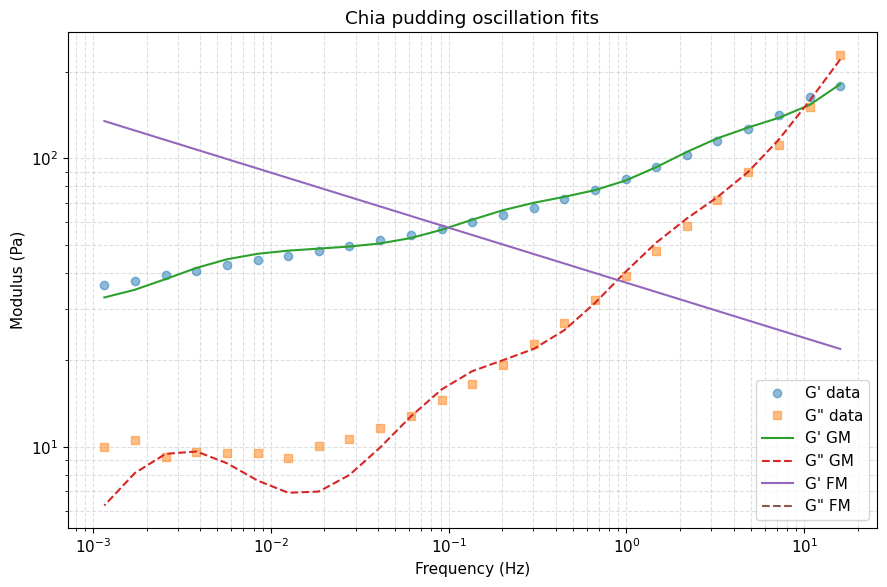

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
if np.isfinite(fm_r2):
    ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
    ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title('Chia pudding oscillation fits')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.285487s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.101308e+02 | time=0.285s | final_gradient_norm=1777101.4551892115


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.272398s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.101308e+02 | time=0.272s | final_gradient_norm=1777101.4551892115


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.205903s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=23 | final_cost=4.487314e+02 | time=0.206s | final_gradient_norm=1299601.1934865206


Element minimization: early termination at n_modes=3 (R²=0.992681 < threshold=0.994859)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.275990s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.885977e+00 | time=0.276s | final_gradient_norm=58.816357214983256


Model ranking (R²): [('gm', 0.996), ('fm', -1.189)]


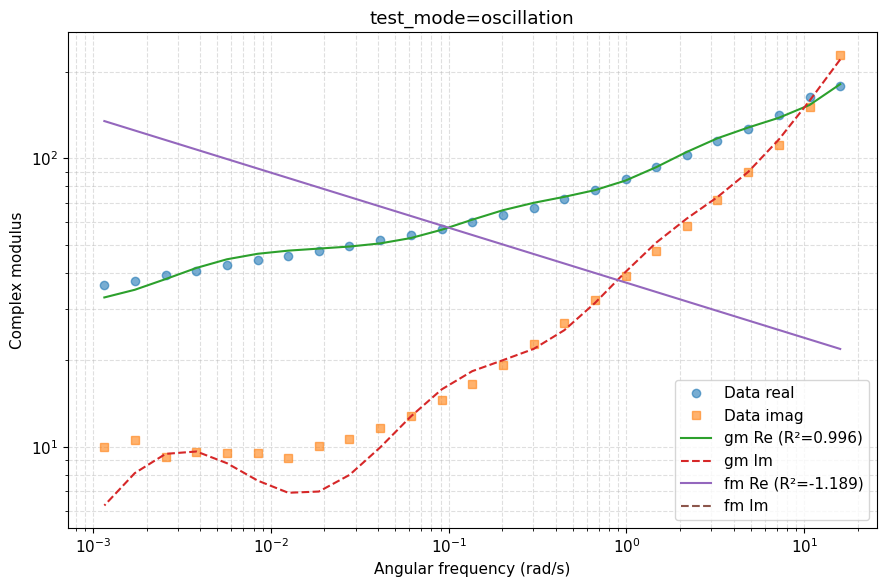

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<57:26,  1.16it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 52/4000 [00:00<00:53, 73.32it/s, 511 steps of size 5.19e-02. acc. prob=0.76]

warmup:   3%|▎         | 106/4000 [00:01<00:25, 151.48it/s, 511 steps of size 5.71e-02. acc. prob=0.77]

warmup:   4%|▎         | 147/4000 [00:01<00:19, 193.11it/s, 63 steps of size 3.20e-02. acc. prob=0.77] 

warmup:   5%|▍         | 185/4000 [00:01<00:17, 219.63it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:   6%|▌         | 220/4000 [00:01<00:15, 239.10it/s, 111 steps of size 4.41e-02. acc. prob=0.78]

warmup:   6%|▋         | 256/4000 [00:01<00:14, 266.20it/s, 255 steps of size 3.20e-02. acc. prob=0.78]

warmup:   7%|▋         | 290/4000 [00:01<00:13, 283.25it/s, 127 steps of size 6.83e-02. acc. prob=0.78]

warmup:   8%|▊         | 336/4000 [00:01<00:11, 328.48it/s, 55 steps of size 4.06e-02. acc. prob=0.78] 

warmup:  10%|▉         | 386/4000 [00:01<00:09, 373.54it/s, 127 steps of size 3.45e-02. acc. prob=0.78]

warmup:  11%|█         | 433/4000 [00:01<00:08, 400.23it/s, 63 steps of size 4.15e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 476/4000 [00:02<00:08, 395.25it/s, 511 steps of size 8.52e-03. acc. prob=0.78]

warmup:  13%|█▎        | 518/4000 [00:02<00:09, 378.59it/s, 127 steps of size 4.01e-02. acc. prob=0.78]

warmup:  14%|█▍        | 562/4000 [00:02<00:08, 386.99it/s, 767 steps of size 1.58e-02. acc. prob=0.78]

warmup:  15%|█▌        | 609/4000 [00:02<00:08, 406.70it/s, 255 steps of size 2.55e-02. acc. prob=0.79]

warmup:  17%|█▋        | 666/4000 [00:02<00:07, 452.55it/s, 47 steps of size 1.52e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 716/4000 [00:02<00:07, 464.32it/s, 127 steps of size 3.03e-02. acc. prob=0.79]

warmup:  19%|█▉        | 767/4000 [00:02<00:06, 477.53it/s, 127 steps of size 4.17e-02. acc. prob=0.79]

warmup:  20%|██        | 818/4000 [00:02<00:06, 485.45it/s, 127 steps of size 2.77e-02. acc. prob=0.79]

warmup:  22%|██▏       | 867/4000 [00:02<00:06, 466.49it/s, 127 steps of size 2.84e-02. acc. prob=0.79]

warmup:  23%|██▎       | 918/4000 [00:03<00:06, 477.96it/s, 255 steps of size 2.27e-02. acc. prob=0.79]

warmup:  24%|██▍       | 967/4000 [00:03<00:06, 463.59it/s, 55 steps of size 5.76e-03. acc. prob=0.79] 

sample:  25%|██▌       | 1014/4000 [00:03<00:06, 460.54it/s, 63 steps of size 2.67e-02. acc. prob=0.97]

sample:  27%|██▋       | 1066/4000 [00:03<00:06, 477.57it/s, 127 steps of size 2.67e-02. acc. prob=0.93]

sample:  28%|██▊       | 1116/4000 [00:03<00:05, 483.90it/s, 255 steps of size 2.67e-02. acc. prob=0.93]

sample:  29%|██▉       | 1167/4000 [00:03<00:05, 491.02it/s, 127 steps of size 2.67e-02. acc. prob=0.92]

sample:  30%|███       | 1217/4000 [00:03<00:05, 491.35it/s, 127 steps of size 2.67e-02. acc. prob=0.93]

sample:  32%|███▏      | 1267/4000 [00:03<00:05, 493.15it/s, 127 steps of size 2.67e-02. acc. prob=0.93]

sample:  33%|███▎      | 1317/4000 [00:03<00:05, 494.13it/s, 63 steps of size 2.67e-02. acc. prob=0.93] 

sample:  34%|███▍      | 1368/4000 [00:03<00:05, 494.58it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  35%|███▌      | 1418/4000 [00:04<00:05, 490.68it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  37%|███▋      | 1468/4000 [00:04<00:05, 445.07it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  38%|███▊      | 1514/4000 [00:04<00:06, 412.19it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  39%|███▉      | 1557/4000 [00:04<00:06, 379.16it/s, 511 steps of size 2.67e-02. acc. prob=0.94]

sample:  40%|███▉      | 1596/4000 [00:04<00:06, 356.82it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  41%|████      | 1633/4000 [00:04<00:06, 350.93it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  42%|████▏     | 1669/4000 [00:04<00:06, 338.76it/s, 63 steps of size 2.67e-02. acc. prob=0.94] 

sample:  43%|████▎     | 1704/4000 [00:04<00:06, 330.06it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  43%|████▎     | 1738/4000 [00:05<00:06, 324.75it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  44%|████▍     | 1771/4000 [00:05<00:07, 306.28it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  45%|████▌     | 1803/4000 [00:05<00:07, 308.83it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  46%|████▌     | 1835/4000 [00:05<00:07, 302.12it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  47%|████▋     | 1873/4000 [00:05<00:06, 323.27it/s, 31 steps of size 2.67e-02. acc. prob=0.94] 

sample:  48%|████▊     | 1909/4000 [00:05<00:06, 332.81it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  49%|████▊     | 1944/4000 [00:05<00:06, 335.88it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  50%|████▉     | 1980/4000 [00:05<00:05, 341.15it/s, 127 steps of size 2.67e-02. acc. prob=0.95]

sample:  50%|█████     | 2020/4000 [00:05<00:05, 356.10it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2056/4000 [00:05<00:05, 341.72it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2091/4000 [00:06<00:05, 333.22it/s, 127 steps of size 2.67e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2125/4000 [00:06<00:05, 327.59it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2164/4000 [00:06<00:05, 342.13it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2199/4000 [00:06<00:05, 331.75it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2234/4000 [00:06<00:05, 334.94it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2268/4000 [00:06<00:05, 332.08it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2302/4000 [00:06<00:05, 320.93it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2335/4000 [00:06<00:05, 322.11it/s, 127 steps of size 2.67e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2368/4000 [00:06<00:05, 301.55it/s, 639 steps of size 2.67e-02. acc. prob=0.95]

sample:  60%|██████    | 2403/4000 [00:07<00:05, 313.49it/s, 127 steps of size 2.67e-02. acc. prob=0.95]

sample:  61%|██████    | 2435/4000 [00:07<00:05, 311.59it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2467/4000 [00:07<00:04, 309.53it/s, 47 steps of size 2.67e-02. acc. prob=0.95] 

sample:  62%|██████▏   | 2499/4000 [00:07<00:05, 289.91it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2529/4000 [00:07<00:05, 283.77it/s, 383 steps of size 2.67e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2561/4000 [00:07<00:04, 293.02it/s, 127 steps of size 2.67e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2591/4000 [00:07<00:04, 286.95it/s, 191 steps of size 2.67e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2624/4000 [00:07<00:04, 296.37it/s, 255 steps of size 2.67e-02. acc. prob=0.95]

sample:  66%|██████▋   | 2654/4000 [00:07<00:04, 294.33it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2684/4000 [00:08<00:04, 291.69it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2714/4000 [00:08<00:04, 283.49it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2750/4000 [00:08<00:04, 302.68it/s, 511 steps of size 2.67e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2781/4000 [00:08<00:04, 297.62it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  70%|███████   | 2811/4000 [00:08<00:04, 289.28it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  71%|███████   | 2841/4000 [00:08<00:04, 276.13it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2870/4000 [00:08<00:04, 278.40it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  72%|███████▎  | 2900/4000 [00:08<00:03, 282.17it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2929/4000 [00:08<00:03, 283.07it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2958/4000 [00:09<00:03, 279.45it/s, 511 steps of size 2.67e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2987/4000 [00:09<00:03, 280.60it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3018/4000 [00:09<00:03, 287.07it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3054/4000 [00:09<00:03, 308.15it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3090/4000 [00:09<00:02, 323.10it/s, 63 steps of size 2.67e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3123/4000 [00:09<00:02, 318.82it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3157/4000 [00:09<00:02, 320.28it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3190/4000 [00:09<00:02, 293.85it/s, 511 steps of size 2.67e-02. acc. prob=0.94]

sample:  81%|████████  | 3228/4000 [00:09<00:02, 315.67it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3261/4000 [00:09<00:02, 314.43it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3293/4000 [00:10<00:02, 300.10it/s, 63 steps of size 2.67e-02. acc. prob=0.94] 

sample:  83%|████████▎ | 3326/4000 [00:10<00:02, 305.12it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3357/4000 [00:10<00:02, 296.98it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3394/4000 [00:10<00:01, 315.83it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3426/4000 [00:10<00:01, 305.93it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3460/4000 [00:10<00:01, 313.56it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3492/4000 [00:10<00:01, 298.28it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3527/4000 [00:10<00:01, 310.12it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3560/4000 [00:10<00:01, 315.45it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3594/4000 [00:11<00:01, 321.26it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  91%|█████████ | 3627/4000 [00:11<00:01, 308.37it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3669/4000 [00:11<00:00, 338.43it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3704/4000 [00:11<00:00, 330.86it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3738/4000 [00:11<00:00, 332.62it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3774/4000 [00:11<00:00, 339.47it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3809/4000 [00:11<00:00, 334.53it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3843/4000 [00:11<00:00, 320.90it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3876/4000 [00:11<00:00, 318.54it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3908/4000 [00:12<00:00, 303.84it/s, 127 steps of size 2.67e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3940/4000 [00:12<00:00, 304.95it/s, 383 steps of size 2.67e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3971/4000 [00:12<00:00, 305.07it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:12<00:00, 324.97it/s, 255 steps of size 2.67e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 62/4000 [00:00<00:06, 614.41it/s, 255 steps of size 3.86e-02. acc. prob=0.76]

warmup:   3%|▎         | 124/4000 [00:00<00:07, 546.80it/s, 127 steps of size 5.76e-02. acc. prob=0.77]

warmup:   4%|▍         | 180/4000 [00:00<00:08, 477.15it/s, 31 steps of size 5.74e-02. acc. prob=0.77] 

warmup:   6%|▌         | 231/4000 [00:00<00:07, 487.61it/s, 63 steps of size 5.37e-02. acc. prob=0.78]

warmup:   7%|▋         | 281/4000 [00:00<00:08, 433.37it/s, 127 steps of size 4.15e-02. acc. prob=0.78]

warmup:   8%|▊         | 326/4000 [00:00<00:08, 417.33it/s, 27 steps of size 2.27e-02. acc. prob=0.78] 

warmup:   9%|▉         | 374/4000 [00:00<00:08, 430.79it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [00:00<00:08, 440.61it/s, 127 steps of size 4.31e-02. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [00:01<00:08, 428.90it/s, 15 steps of size 5.92e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 510/4000 [00:01<00:08, 390.29it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [00:01<00:08, 394.56it/s, 127 steps of size 5.77e-02. acc. prob=0.79]

warmup:  15%|█▍        | 596/4000 [00:01<00:08, 409.94it/s, 127 steps of size 2.55e-02. acc. prob=0.79]

warmup:  16%|█▌        | 638/4000 [00:01<00:08, 411.56it/s, 127 steps of size 2.98e-02. acc. prob=0.79]

warmup:  17%|█▋        | 686/4000 [00:01<00:07, 430.75it/s, 127 steps of size 4.36e-02. acc. prob=0.79]

warmup:  18%|█▊        | 734/4000 [00:01<00:07, 442.90it/s, 127 steps of size 4.61e-02. acc. prob=0.79]

warmup:  20%|█▉        | 784/4000 [00:01<00:07, 457.54it/s, 255 steps of size 2.55e-02. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [00:01<00:06, 460.51it/s, 223 steps of size 4.89e-02. acc. prob=0.79]

warmup:  22%|██▏       | 884/4000 [00:01<00:06, 477.31it/s, 127 steps of size 3.32e-02. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [00:02<00:06, 485.51it/s, 127 steps of size 2.63e-02. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [00:02<00:07, 402.77it/s, 127 steps of size 4.58e-02. acc. prob=0.79]

sample:  26%|██▌       | 1027/4000 [00:02<00:07, 373.03it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  27%|██▋       | 1067/4000 [00:02<00:08, 360.31it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  28%|██▊       | 1105/4000 [00:02<00:08, 360.39it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  29%|██▊       | 1142/4000 [00:02<00:08, 354.20it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  29%|██▉       | 1179/4000 [00:02<00:07, 357.22it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  30%|███       | 1220/4000 [00:02<00:07, 370.35it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  31%|███▏      | 1258/4000 [00:03<00:07, 365.41it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  32%|███▏      | 1296/4000 [00:03<00:07, 368.64it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  33%|███▎      | 1334/4000 [00:03<00:07, 349.19it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  34%|███▍      | 1370/4000 [00:03<00:07, 348.89it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  35%|███▌      | 1407/4000 [00:03<00:07, 353.75it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  36%|███▌      | 1443/4000 [00:03<00:07, 354.39it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  37%|███▋      | 1482/4000 [00:03<00:06, 361.98it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  38%|███▊      | 1519/4000 [00:03<00:06, 357.81it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  39%|███▉      | 1555/4000 [00:03<00:06, 354.87it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  40%|███▉      | 1592/4000 [00:03<00:06, 356.20it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  41%|████      | 1630/4000 [00:04<00:06, 362.05it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  42%|████▏     | 1667/4000 [00:04<00:06, 360.92it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  43%|████▎     | 1704/4000 [00:04<00:06, 353.73it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  44%|████▎     | 1742/4000 [00:04<00:06, 360.13it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  44%|████▍     | 1779/4000 [00:04<00:06, 320.64it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  45%|████▌     | 1812/4000 [00:04<00:07, 281.04it/s, 63 steps of size 2.04e-02. acc. prob=0.97] 

sample:  46%|████▌     | 1842/4000 [00:04<00:08, 261.92it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  47%|████▋     | 1870/4000 [00:04<00:08, 255.99it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  47%|████▋     | 1897/4000 [00:05<00:08, 258.02it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  48%|████▊     | 1924/4000 [00:05<00:07, 259.71it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  49%|████▉     | 1954/4000 [00:05<00:07, 269.42it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  50%|████▉     | 1982/4000 [00:05<00:08, 242.34it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  50%|█████     | 2011/4000 [00:05<00:07, 253.26it/s, 639 steps of size 2.04e-02. acc. prob=0.97]

sample:  51%|█████     | 2037/4000 [00:05<00:07, 245.91it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  52%|█████▏    | 2064/4000 [00:05<00:07, 250.11it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  52%|█████▏    | 2090/4000 [00:05<00:07, 244.54it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  53%|█████▎    | 2115/4000 [00:05<00:08, 228.62it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  53%|█████▎    | 2139/4000 [00:06<00:08, 229.57it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  54%|█████▍    | 2163/4000 [00:06<00:08, 228.51it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  55%|█████▍    | 2190/4000 [00:06<00:07, 239.85it/s, 767 steps of size 2.04e-02. acc. prob=0.97]

sample:  55%|█████▌    | 2218/4000 [00:06<00:07, 248.30it/s, 383 steps of size 2.04e-02. acc. prob=0.97]

sample:  56%|█████▌    | 2243/4000 [00:06<00:07, 230.71it/s, 767 steps of size 2.04e-02. acc. prob=0.97]

sample:  57%|█████▋    | 2267/4000 [00:06<00:07, 229.87it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  57%|█████▋    | 2295/4000 [00:06<00:07, 242.93it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  58%|█████▊    | 2320/4000 [00:06<00:07, 228.41it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  59%|█████▊    | 2344/4000 [00:06<00:07, 214.54it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  59%|█████▉    | 2370/4000 [00:07<00:07, 226.55it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  60%|█████▉    | 2395/4000 [00:07<00:06, 232.67it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  61%|██████    | 2422/4000 [00:07<00:06, 242.16it/s, 383 steps of size 2.04e-02. acc. prob=0.97]

sample:  61%|██████    | 2447/4000 [00:07<00:06, 223.85it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  62%|██████▏   | 2470/4000 [00:07<00:06, 220.99it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  62%|██████▏   | 2493/4000 [00:07<00:06, 217.24it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  63%|██████▎   | 2520/4000 [00:07<00:06, 231.42it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  64%|██████▎   | 2549/4000 [00:07<00:05, 246.59it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  64%|██████▍   | 2574/4000 [00:07<00:05, 238.74it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  65%|██████▍   | 2599/4000 [00:08<00:06, 227.32it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  66%|██████▌   | 2622/4000 [00:08<00:06, 227.58it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  66%|██████▌   | 2649/4000 [00:08<00:05, 238.25it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  67%|██████▋   | 2678/4000 [00:08<00:05, 249.74it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  68%|██████▊   | 2704/4000 [00:08<00:05, 234.92it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  68%|██████▊   | 2728/4000 [00:08<00:05, 219.39it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  69%|██████▉   | 2751/4000 [00:08<00:05, 215.00it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  69%|██████▉   | 2774/4000 [00:08<00:05, 215.86it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  70%|██████▉   | 2797/4000 [00:08<00:05, 217.31it/s, 383 steps of size 2.04e-02. acc. prob=0.97]

sample:  70%|███████   | 2819/4000 [00:09<00:05, 212.95it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  71%|███████   | 2841/4000 [00:09<00:05, 213.30it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  72%|███████▏  | 2863/4000 [00:09<00:05, 214.02it/s, 159 steps of size 2.04e-02. acc. prob=0.97]

sample:  72%|███████▏  | 2887/4000 [00:09<00:05, 218.34it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  73%|███████▎  | 2909/4000 [00:09<00:05, 206.99it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  73%|███████▎  | 2935/4000 [00:09<00:04, 219.60it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  74%|███████▍  | 2958/4000 [00:09<00:04, 211.33it/s, 31 steps of size 2.04e-02. acc. prob=0.97] 

sample:  74%|███████▍  | 2980/4000 [00:09<00:04, 209.32it/s, 383 steps of size 2.04e-02. acc. prob=0.97]

sample:  75%|███████▌  | 3002/4000 [00:09<00:04, 206.78it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  76%|███████▌  | 3028/4000 [00:10<00:04, 216.64it/s, 767 steps of size 2.04e-02. acc. prob=0.97]

sample:  76%|███████▋  | 3051/4000 [00:10<00:04, 217.33it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  77%|███████▋  | 3073/4000 [00:10<00:04, 214.45it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  77%|███████▋  | 3098/4000 [00:10<00:04, 220.96it/s, 767 steps of size 2.04e-02. acc. prob=0.97]

sample:  78%|███████▊  | 3121/4000 [00:10<00:03, 220.07it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  79%|███████▊  | 3145/4000 [00:10<00:03, 223.89it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  79%|███████▉  | 3172/4000 [00:10<00:03, 236.40it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  80%|███████▉  | 3196/4000 [00:10<00:03, 228.91it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  80%|████████  | 3219/4000 [00:10<00:03, 218.21it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  81%|████████  | 3243/4000 [00:10<00:03, 224.05it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  82%|████████▏ | 3266/4000 [00:11<00:03, 218.13it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  82%|████████▏ | 3290/4000 [00:11<00:03, 223.53it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  83%|████████▎ | 3313/4000 [00:11<00:03, 221.24it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  83%|████████▎ | 3336/4000 [00:11<00:03, 211.58it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  84%|████████▍ | 3358/4000 [00:11<00:03, 208.13it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  85%|████████▍ | 3384/4000 [00:11<00:02, 222.22it/s, 63 steps of size 2.04e-02. acc. prob=0.97] 

sample:  85%|████████▌ | 3409/4000 [00:11<00:02, 229.17it/s, 223 steps of size 2.04e-02. acc. prob=0.97]

sample:  86%|████████▌ | 3433/4000 [00:11<00:02, 231.00it/s, 599 steps of size 2.04e-02. acc. prob=0.97]

sample:  86%|████████▋ | 3457/4000 [00:11<00:02, 231.48it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  87%|████████▋ | 3481/4000 [00:12<00:02, 229.71it/s, 287 steps of size 2.04e-02. acc. prob=0.97]

sample:  88%|████████▊ | 3505/4000 [00:12<00:02, 228.40it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  88%|████████▊ | 3529/4000 [00:12<00:02, 231.57it/s, 191 steps of size 2.04e-02. acc. prob=0.97]

sample:  89%|████████▉ | 3555/4000 [00:12<00:01, 235.94it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  89%|████████▉ | 3579/4000 [00:12<00:01, 228.17it/s, 383 steps of size 2.04e-02. acc. prob=0.97]

sample:  90%|█████████ | 3605/4000 [00:12<00:01, 235.86it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  91%|█████████ | 3632/4000 [00:12<00:01, 244.88it/s, 63 steps of size 2.04e-02. acc. prob=0.97] 

sample:  91%|█████████▏| 3657/4000 [00:12<00:01, 230.37it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  92%|█████████▏| 3681/4000 [00:12<00:01, 221.83it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  93%|█████████▎| 3704/4000 [00:13<00:01, 220.97it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  93%|█████████▎| 3732/4000 [00:13<00:01, 236.52it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  94%|█████████▍| 3756/4000 [00:13<00:01, 237.14it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  95%|█████████▍| 3784/4000 [00:13<00:00, 248.71it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample:  95%|█████████▌| 3809/4000 [00:13<00:00, 226.88it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

sample:  96%|█████████▌| 3836/4000 [00:13<00:00, 235.59it/s, 767 steps of size 2.04e-02. acc. prob=0.97]

sample:  96%|█████████▋| 3860/4000 [00:13<00:00, 230.67it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  97%|█████████▋| 3886/4000 [00:13<00:00, 237.62it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  98%|█████████▊| 3910/4000 [00:13<00:00, 236.75it/s, 63 steps of size 2.04e-02. acc. prob=0.97] 

sample:  98%|█████████▊| 3934/4000 [00:13<00:00, 231.58it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample:  99%|█████████▉| 3958/4000 [00:14<00:00, 225.91it/s, 255 steps of size 2.04e-02. acc. prob=0.97]

sample: 100%|█████████▉| 3982/4000 [00:14<00:00, 226.76it/s, 511 steps of size 2.04e-02. acc. prob=0.97]

sample: 100%|██████████| 4000/4000 [00:14<00:00, 280.45it/s, 127 steps of size 2.04e-02. acc. prob=0.97]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 48/4000 [00:00<00:08, 478.35it/s, 255 steps of size 3.60e-02. acc. prob=0.75]

warmup:   3%|▎         | 109/4000 [00:00<00:07, 536.62it/s, 511 steps of size 1.36e-02. acc. prob=0.76]

warmup:   4%|▍         | 163/4000 [00:00<00:08, 469.30it/s, 127 steps of size 5.24e-02. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:00<00:08, 444.44it/s, 127 steps of size 4.65e-02. acc. prob=0.78]

warmup:   6%|▋         | 256/4000 [00:00<00:09, 401.62it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:   7%|▋         | 297/4000 [00:00<00:10, 367.34it/s, 127 steps of size 1.77e-02. acc. prob=0.78]

warmup:   8%|▊         | 336/4000 [00:00<00:09, 371.70it/s, 255 steps of size 3.47e-02. acc. prob=0.78]

warmup:  10%|▉         | 381/4000 [00:00<00:09, 393.22it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  11%|█         | 423/4000 [00:01<00:08, 397.70it/s, 255 steps of size 3.34e-02. acc. prob=0.78]

warmup:  12%|█▏        | 464/4000 [00:01<00:08, 396.49it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  13%|█▎        | 505/4000 [00:01<00:08, 400.08it/s, 63 steps of size 2.87e-02. acc. prob=0.78] 

warmup:  14%|█▎        | 548/4000 [00:01<00:08, 406.55it/s, 127 steps of size 3.54e-02. acc. prob=0.79]

warmup:  15%|█▍        | 591/4000 [00:01<00:08, 411.79it/s, 255 steps of size 2.58e-02. acc. prob=0.79]

warmup:  16%|█▌        | 648/4000 [00:01<00:07, 458.04it/s, 63 steps of size 3.70e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 697/4000 [00:01<00:07, 467.44it/s, 63 steps of size 3.44e-02. acc. prob=0.79]

warmup:  19%|█▉        | 751/4000 [00:01<00:06, 487.77it/s, 127 steps of size 4.23e-02. acc. prob=0.79]

warmup:  20%|██        | 807/4000 [00:01<00:06, 507.73it/s, 255 steps of size 2.59e-02. acc. prob=0.79]

warmup:  21%|██▏       | 858/4000 [00:01<00:06, 494.13it/s, 69 steps of size 4.34e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 913/4000 [00:02<00:06, 508.97it/s, 127 steps of size 3.71e-02. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [00:02<00:06, 495.02it/s, 255 steps of size 2.79e-02. acc. prob=0.79]

sample:  25%|██▌       | 1015/4000 [00:02<00:07, 420.97it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  26%|██▋       | 1060/4000 [00:02<00:07, 396.73it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  28%|██▊       | 1102/4000 [00:02<00:07, 379.50it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  29%|██▊       | 1141/4000 [00:02<00:07, 361.84it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  29%|██▉       | 1178/4000 [00:02<00:07, 357.84it/s, 511 steps of size 2.05e-02. acc. prob=0.97]

sample:  30%|███       | 1215/4000 [00:02<00:07, 352.63it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  31%|███▏      | 1252/4000 [00:03<00:07, 355.30it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  32%|███▏      | 1288/4000 [00:03<00:07, 345.04it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  33%|███▎      | 1325/4000 [00:03<00:07, 350.74it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  34%|███▍      | 1361/4000 [00:03<00:07, 347.67it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  35%|███▍      | 1396/4000 [00:03<00:07, 344.72it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  36%|███▌      | 1433/4000 [00:03<00:07, 351.43it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  37%|███▋      | 1469/4000 [00:03<00:07, 349.61it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  38%|███▊      | 1506/4000 [00:03<00:07, 353.80it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  39%|███▊      | 1542/4000 [00:03<00:07, 348.91it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  40%|███▉      | 1580/4000 [00:03<00:06, 357.60it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  40%|████      | 1616/4000 [00:04<00:06, 353.39it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  41%|████▏     | 1652/4000 [00:04<00:06, 350.19it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  42%|████▏     | 1688/4000 [00:04<00:06, 350.91it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  43%|████▎     | 1724/4000 [00:04<00:06, 348.39it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  44%|████▍     | 1760/4000 [00:04<00:06, 350.53it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  45%|████▍     | 1796/4000 [00:04<00:06, 339.25it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  46%|████▌     | 1831/4000 [00:04<00:06, 334.31it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  47%|████▋     | 1865/4000 [00:04<00:06, 329.15it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  47%|████▋     | 1899/4000 [00:04<00:06, 328.85it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  48%|████▊     | 1932/4000 [00:05<00:06, 311.82it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  49%|████▉     | 1964/4000 [00:05<00:07, 287.90it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  50%|████▉     | 1994/4000 [00:05<00:07, 278.04it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  51%|█████     | 2023/4000 [00:05<00:07, 275.34it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  51%|█████▏    | 2054/4000 [00:05<00:06, 282.93it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  52%|█████▏    | 2083/4000 [00:05<00:06, 276.11it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2111/4000 [00:05<00:07, 253.82it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  53%|█████▎    | 2138/4000 [00:05<00:07, 257.23it/s, 127 steps of size 2.05e-02. acc. prob=0.96]

sample:  54%|█████▍    | 2165/4000 [00:05<00:07, 252.37it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  55%|█████▍    | 2195/4000 [00:06<00:06, 263.81it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2222/4000 [00:06<00:06, 260.51it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  56%|█████▌    | 2249/4000 [00:06<00:07, 241.91it/s, 383 steps of size 2.05e-02. acc. prob=0.96]

sample:  57%|█████▋    | 2275/4000 [00:06<00:07, 244.61it/s, 383 steps of size 2.05e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2302/4000 [00:06<00:06, 249.54it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  58%|█████▊    | 2330/4000 [00:06<00:06, 257.41it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  59%|█████▉    | 2356/4000 [00:06<00:06, 253.80it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  60%|█████▉    | 2388/4000 [00:06<00:05, 272.04it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  60%|██████    | 2416/4000 [00:06<00:06, 259.84it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  61%|██████    | 2445/4000 [00:07<00:05, 265.43it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2472/4000 [00:07<00:05, 263.13it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  62%|██████▏   | 2499/4000 [00:07<00:05, 256.93it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  63%|██████▎   | 2525/4000 [00:07<00:05, 251.55it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2553/4000 [00:07<00:05, 258.76it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  64%|██████▍   | 2579/4000 [00:07<00:05, 246.78it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  65%|██████▌   | 2605/4000 [00:07<00:05, 247.60it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  66%|██████▌   | 2634/4000 [00:07<00:05, 259.09it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2663/4000 [00:07<00:04, 267.93it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  67%|██████▋   | 2691/4000 [00:07<00:04, 268.03it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  68%|██████▊   | 2718/4000 [00:08<00:04, 257.73it/s, 639 steps of size 2.05e-02. acc. prob=0.96]

sample:  69%|██████▊   | 2745/4000 [00:08<00:04, 258.26it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  69%|██████▉   | 2771/4000 [00:08<00:04, 253.27it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  70%|██████▉   | 2797/4000 [00:08<00:04, 242.72it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  71%|███████   | 2827/4000 [00:08<00:04, 256.02it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  71%|███████▏  | 2853/4000 [00:08<00:04, 255.74it/s, 511 steps of size 2.05e-02. acc. prob=0.96]

sample:  72%|███████▏  | 2879/4000 [00:08<00:04, 250.08it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2905/4000 [00:08<00:04, 247.07it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  73%|███████▎  | 2932/4000 [00:08<00:04, 253.28it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  74%|███████▍  | 2958/4000 [00:09<00:04, 252.86it/s, 255 steps of size 2.05e-02. acc. prob=0.96]

sample:  75%|███████▍  | 2984/4000 [00:09<00:04, 248.06it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  75%|███████▌  | 3014/4000 [00:09<00:03, 262.29it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  76%|███████▌  | 3041/4000 [00:09<00:03, 255.57it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  77%|███████▋  | 3067/4000 [00:09<00:03, 255.74it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  77%|███████▋  | 3093/4000 [00:09<00:03, 247.11it/s, 511 steps of size 2.05e-02. acc. prob=0.97]

sample:  78%|███████▊  | 3119/4000 [00:09<00:03, 249.07it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  79%|███████▊  | 3145/4000 [00:09<00:03, 251.19it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  79%|███████▉  | 3171/4000 [00:09<00:03, 238.53it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  80%|███████▉  | 3197/4000 [00:10<00:03, 242.71it/s, 511 steps of size 2.05e-02. acc. prob=0.97]

sample:  81%|████████  | 3222/4000 [00:10<00:03, 243.12it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  81%|████████  | 3247/4000 [00:10<00:03, 235.77it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  82%|████████▏ | 3276/4000 [00:10<00:02, 250.38it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  83%|████████▎ | 3308/4000 [00:10<00:02, 269.53it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  84%|████████▎ | 3342/4000 [00:10<00:02, 287.80it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  85%|████████▍ | 3381/4000 [00:10<00:01, 315.99it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  85%|████████▌ | 3417/4000 [00:10<00:01, 327.96it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  86%|████████▋ | 3452/4000 [00:10<00:01, 332.60it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  87%|████████▋ | 3489/4000 [00:10<00:01, 342.32it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  88%|████████▊ | 3524/4000 [00:11<00:01, 340.25it/s, 63 steps of size 2.05e-02. acc. prob=0.97] 

sample:  89%|████████▉ | 3564/4000 [00:11<00:01, 355.59it/s, 383 steps of size 2.05e-02. acc. prob=0.97]

sample:  90%|█████████ | 3604/4000 [00:11<00:01, 367.47it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  91%|█████████ | 3641/4000 [00:11<00:01, 349.51it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  92%|█████████▏| 3681/4000 [00:11<00:00, 360.42it/s, 191 steps of size 2.05e-02. acc. prob=0.97]

sample:  93%|█████████▎| 3718/4000 [00:11<00:00, 351.25it/s, 63 steps of size 2.05e-02. acc. prob=0.97] 

sample:  94%|█████████▍| 3757/4000 [00:11<00:00, 359.04it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  95%|█████████▍| 3794/4000 [00:11<00:00, 357.28it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  96%|█████████▌| 3830/4000 [00:11<00:00, 355.17it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

sample:  97%|█████████▋| 3866/4000 [00:11<00:00, 352.68it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  98%|█████████▊| 3902/4000 [00:12<00:00, 353.72it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  98%|█████████▊| 3938/4000 [00:12<00:00, 354.16it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample:  99%|█████████▉| 3974/4000 [00:12<00:00, 353.18it/s, 255 steps of size 2.05e-02. acc. prob=0.97]

sample: 100%|██████████| 4000/4000 [00:12<00:00, 323.43it/s, 127 steps of size 2.05e-02. acc. prob=0.97]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 58/4000 [00:00<00:06, 578.73it/s, 95 steps of size 9.64e-02. acc. prob=0.76]

warmup:   3%|▎         | 121/4000 [00:00<00:06, 606.38it/s, 63 steps of size 4.77e-02. acc. prob=0.77]

warmup:   5%|▌         | 204/4000 [00:00<00:05, 707.50it/s, 19 steps of size 1.53e-01. acc. prob=0.78]

warmup:   9%|▊         | 344/4000 [00:00<00:03, 978.32it/s, 15 steps of size 7.88e-02. acc. prob=0.78]

warmup:  13%|█▎        | 501/4000 [00:00<00:02, 1190.12it/s, 15 steps of size 1.76e-01. acc. prob=0.79]

warmup:  17%|█▋        | 669/4000 [00:00<00:02, 1352.96it/s, 31 steps of size 1.95e-01. acc. prob=0.79]

warmup:  21%|██        | 842/4000 [00:00<00:02, 1472.61it/s, 31 steps of size 1.46e-01. acc. prob=0.79]

sample:  25%|██▌       | 1005/4000 [00:00<00:01, 1519.95it/s, 31 steps of size 1.55e-01. acc. prob=0.96]

sample:  29%|██▉       | 1157/4000 [00:00<00:01, 1505.89it/s, 31 steps of size 1.55e-01. acc. prob=0.93]

sample:  33%|███▎      | 1309/4000 [00:01<00:01, 1508.89it/s, 15 steps of size 1.55e-01. acc. prob=0.78]

sample:  36%|███▋      | 1460/4000 [00:01<00:01, 1487.50it/s, 15 steps of size 1.55e-01. acc. prob=0.72]

sample:  41%|████      | 1626/4000 [00:01<00:01, 1538.27it/s, 15 steps of size 1.55e-01. acc. prob=0.60]

sample:  45%|████▍     | 1790/4000 [00:01<00:01, 1568.52it/s, 25 steps of size 1.55e-01. acc. prob=0.55]

sample:  49%|████▊     | 1947/4000 [00:01<00:01, 1540.88it/s, 31 steps of size 1.55e-01. acc. prob=0.57]

sample:  53%|█████▎    | 2102/4000 [00:01<00:01, 1532.82it/s, 31 steps of size 1.55e-01. acc. prob=0.62]

sample:  56%|█████▋    | 2256/4000 [00:01<00:01, 1531.94it/s, 15 steps of size 1.55e-01. acc. prob=0.66]

sample:  60%|██████    | 2410/4000 [00:01<00:01, 1533.22it/s, 31 steps of size 1.55e-01. acc. prob=0.69]

sample:  64%|██████▍   | 2565/4000 [00:01<00:00, 1537.94it/s, 31 steps of size 1.55e-01. acc. prob=0.71]

sample:  68%|██████▊   | 2731/4000 [00:01<00:00, 1572.73it/s, 13 steps of size 1.55e-01. acc. prob=0.69]

sample:  73%|███████▎  | 2917/4000 [00:02<00:00, 1657.60it/s, 23 steps of size 1.55e-01. acc. prob=0.64]

sample:  78%|███████▊  | 3122/4000 [00:02<00:00, 1772.62it/s, 63 steps of size 1.55e-01. acc. prob=0.59]

sample:  83%|████████▎ | 3315/4000 [00:02<00:00, 1819.49it/s, 11 steps of size 1.55e-01. acc. prob=0.56]

sample:  88%|████████▊ | 3501/4000 [00:02<00:00, 1831.17it/s, 31 steps of size 1.55e-01. acc. prob=0.54]

sample:  92%|█████████▏| 3685/4000 [00:02<00:00, 1711.33it/s, 31 steps of size 1.55e-01. acc. prob=0.56]

sample:  96%|█████████▋| 3858/4000 [00:02<00:00, 1662.00it/s, 31 steps of size 1.55e-01. acc. prob=0.58]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1509.61it/s, 31 steps of size 1.55e-01. acc. prob=0.60]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
